In [275]:
# user parameters
key = open('../api-key/omdb.txt', 'r').read()
searchlist = ['love', 'ball', 'war', 'book', 'game', 'future', 'earth', 'princess']

In [276]:
import pandas as pd
import requests
import json

# helper functions
def getratings(ratinglist):
    """ 
     TODO: comment this helper function
       """
    returnlist = []
    for rating in ratinglist:
        dict_r = dict(rating)
        return_r = [dict_r['Source'], dict_r['Value']]
        returnlist.append(return_r)
    return returnlist

def load_data(key, searchlist):
    """ 
    load_data extracts movie data from OMDB API, based on a list of words provided in searchlist
    :param key: apikey to access the api
    :param searchlist: list of stings to search for in movie titles
    :return:  for each word in searchlist, 10 movies with the word in its title and corresponding omdb data
    """
    # initialize empty dataframe
    moviedf = pd.DataFrame()
    # retrieve the data from api and get 10 results based on keyword 
    for word in searchlist: 
        response_title = requests.get('http://www.omdbapi.com/?apikey={}&s={}&type=movie'.format(key, word))
        title_txt = response_title.text
        parse_title = json.loads(title_txt)
        if 'Search' in parse_title:
            titledf = parse_title['Search']
            titledf = pd.DataFrame.from_dict(titledf)
            titles = titledf['Title']
            # for each movietitle, acquire extra data
            for title in titles:
                response_data = requests.get('http://www.omdbapi.com/?apikey={}&t={}&plot=short'.format(key, title))
                data_txt = response_data.text
                parse_data = pd.read_json(data_txt)

                # convert multiple rows per movie into 1 row per movie by groupby and applying a function to 'Ratings' column
                groupby_cols = list(parse_data.columns)
                groupby_cols.remove('Ratings')
                parse_data = (parse_data.groupby(groupby_cols)
                .agg({'Ratings': lambda x: getratings(x)},axis=1)
                .reset_index())

                parse_data['search_word'] = word
                # add data to the final dataframe
                moviedf = pd.concat([moviedf, parse_data])
    # make sure there are no duplicates
    moviedf.reset_index(drop=True, inplace=True)
    moviedf = moviedf.loc[moviedf.astype(str).drop_duplicates().index]
    moviedf.to_excel('test.xlsx')
    return moviedf

In [277]:
moviedf = load_data(key, searchlist)
moviedf.head()

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response,Ratings,search_word
0,"Crazy, Stupid, Love.",2011,PG-13,29 Jul 2011,118 min,"Comedy, Drama, Romance","Glenn Ficarra, John Requa",Dan Fogelman,"Steve Carell, Ryan Gosling, Julianne Moore",A middle-aged husband's life changes dramatica...,...,"535,806",tt1570728,movie,13 Apr 2016,"$84,379,584","Carousel, DiNovi Pictures",N/A,True,"[[Internet Movie Database, 7.4/10], [Rotten To...",love
1,Love Actually,2003,R,14 Nov 2003,135 min,"Comedy, Drama, Romance",Richard Curtis,Richard Curtis,"Hugh Grant, Martine McCutcheon, Liam Neeson",Follows the lives of eight very different coup...,...,"504,238",tt0314331,movie,27 Apr 2004,"$59,696,144",N/A,N/A,True,"[[Internet Movie Database, 7.6/10], [Rotten To...",love
2,Dr. Strangelove or: How I Learned to Stop Worr...,1964,PG,29 Jan 1964,95 min,"Comedy, War",Stanley Kubrick,"Stanley Kubrick, Terry Southern, Peter George","Peter Sellers, George C. Scott, Sterling Hayden",An insane American general orders a bombing at...,...,"501,965",tt0057012,movie,21 Oct 2003,"$9,440,272",N/A,N/A,True,"[[Internet Movie Database, 8.4/10], [Rotten To...",love
3,Thor: Love and Thunder,2022,PG-13,08 Jul 2022,118 min,"Action, Adventure, Comedy",Taika Waititi,"Taika Waititi, Jennifer Kaytin Robinson, Stan Lee","Chris Hemsworth, Natalie Portman, Christian Bale","Thor enlists the help of Valkyrie, Korg and ex...",...,"370,299",tt10648342,movie,08 Sep 2022,"$343,256,830",N/A,N/A,True,"[[Internet Movie Database, 6.2/10], [Rotten To...",love
4,Shakespeare in Love,1998,R,08 Jan 1999,123 min,"Comedy, Drama, History",John Madden,"Marc Norman, Tom Stoppard","Gwyneth Paltrow, Joseph Fiennes, Geoffrey Rush","The world's greatest ever playwright, William ...",...,"229,779",tt0138097,movie,07 Dec 1999,"$100,317,794",N/A,N/A,True,"[[Internet Movie Database, 7.1/10], [Rotten To...",love


In [278]:
num_cols = ['Runtime', 'Metascore', 'imdbRating', 'imdbVotes', 'BoxOffice']
text_cols = ['Plot', 'Title']
X_cols = text_cols + num_cols
y_col = 'Genre'

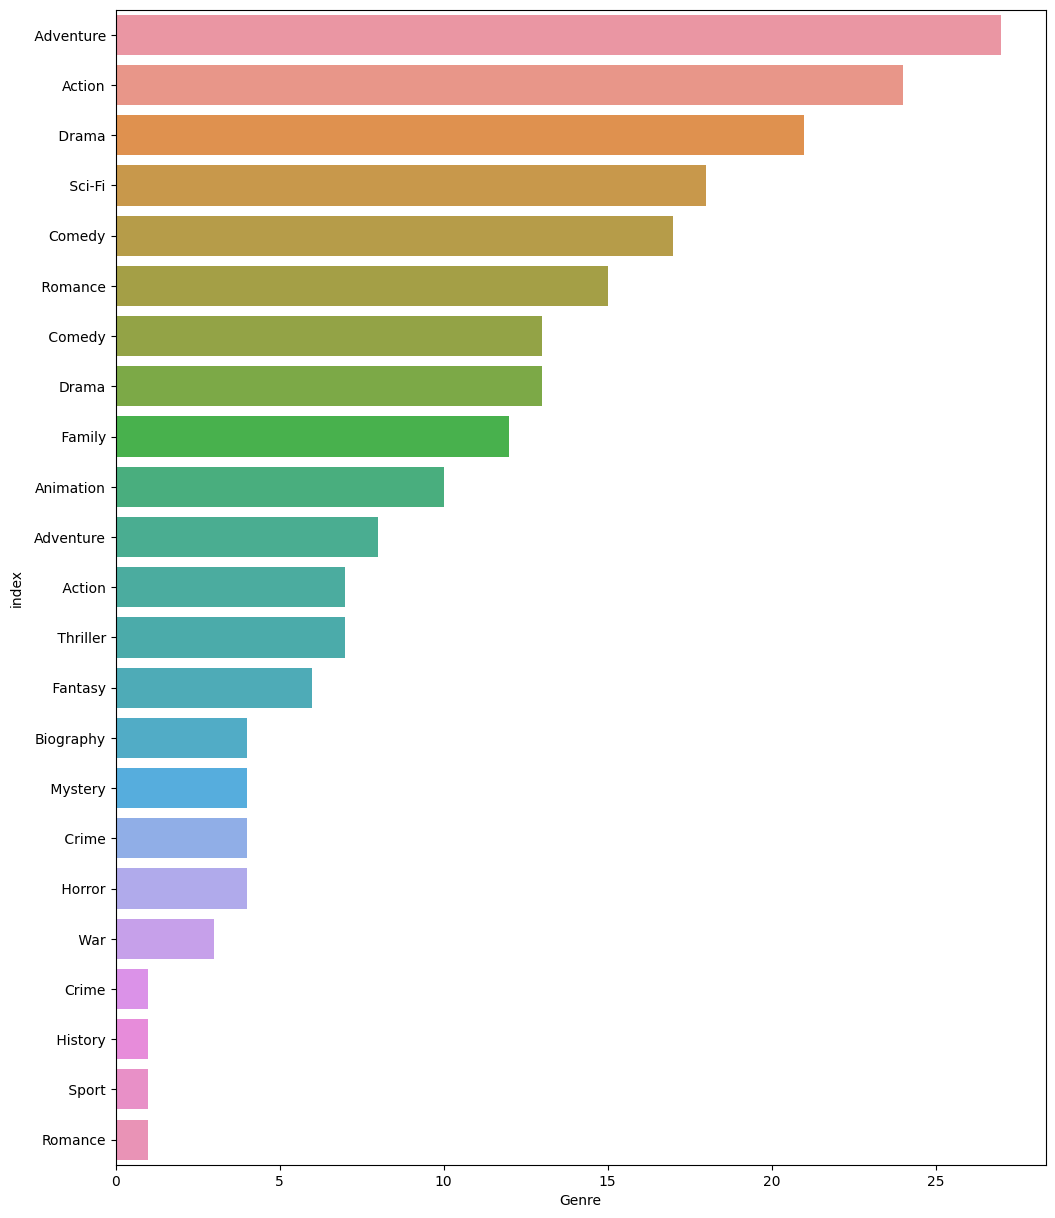

In [361]:

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

genre_list = moviedf['Genre'].apply(lambda x: x.split(',')).tolist()
genre_list = [item for sublist in genre_list for item in sublist]
count = Counter(genre_list)
countdf = pd.DataFrame.from_dict(count, orient='index', columns=['Count']).reset_index().sort_values(by='Count', ascending=False)
# countdf
# g = moviedf.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=countdf, x="Count", y = "index") 
ax.set(xlabel = 'Genre') 
plt.show()

In [279]:
import re
import string
# data preprocessing
def process_text(text):
    text = str(text).lower()
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", " ", text
    )
    text = " ".join(text.split())
    return text

def process_num(df, num_cols):
    for col in list(num_cols):
        df.loc[:,col] = df[col].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
    return df

In [280]:
processed_df = moviedf.copy()
processed_df['Plot'] = processed_df.Plot.map(process_text)
processed_df = process_num(processed_df, num_cols)
X = processed_df[X_cols]
X.head()

,Plot,Title,Runtime,Metascore,imdbRating,imdbVotes,BoxOffice
0,a middle aged husband s life changes dramatica...,"Crazy, Stupid, Love.",118.0,68.0,74.0,535806,84379584.0
1,follows the lives of eight very different coup...,Love Actually,135.0,55.0,76.0,504238,59696144.0
2,an insane american general orders a bombing at...,Dr. Strangelove or: How I Learned to Stop Worr...,95.0,97.0,84.0,501965,9440272.0
3,thor enlists the help of valkyrie korg and ex ...,Thor: Love and Thunder,118.0,57.0,62.0,370299,343256830.0
4,the world s greatest ever playwright william s...,Shakespeare in Love,123.0,87.0,71.0,229779,100317794.0


In [281]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()
genre = [x.split(', ') for x in list(moviedf[y_col])]
y = multilabel_binarizer.fit_transform(genre)
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [282]:
multilabel_binarizer.classes_

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Mystery',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War'], dtype=object)

In [283]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(62, 7) (16, 7) (62, 17) (16, 17)


In [302]:
from sklearn.calibration import LinearSVC
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.problem_transform import BinaryRelevance 
from skmultilearn.adapt import MLkNN

def get_col_data(x, cols):
    return x[cols]

def get_text_data(x, col):
    return x[col].values.ravel()

transformer_text = FunctionTransformer(get_text_data, kw_args={'col' : 'Plot'})
transformer_num = FunctionTransformer(get_col_data, kw_args={'cols' : num_cols})

num_pipeline = Pipeline([
('selector', transformer_num),
('imputer', SimpleImputer(strategy='median')),
('std_scaler', StandardScaler())
])

text_pipeline = Pipeline(
[   
    ('selector', transformer_text),
    ("vect", TfidfVectorizer(stop_words='english', analyzer='word')),
])



data_pipeline = Pipeline([
    ('features', FeatureUnion([
        ('numeric_feat', num_pipeline),
        ('text_feat', text_pipeline)
    ])),
    ('clf', OneVsRestClassifier(LinearSVC(dual=True)))
])

# data_pipeline


In [303]:
y_train.shape, y_test.shape

((62, 17), (16, 17))

In [296]:
import numpy as np
unique_train = [list(x) for x in set(tuple(x) for x in y_train)]
unique_test = [list(x) for x in set(tuple(x) for x in y_test)]
len(unique_train), len(unique_test)

(42, 14)

In [317]:
from statistics import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import warnings
# warnings.filterwarnings("ignore")

param_grid = [
    { 
      'clf__estimator': [LinearSVC(), LogisticRegression(), SVC()],
      "clf__estimator__C": [0.1, 1, 10, 20, 30, 100]
    }]

scoring = {'F1': 'f1_micro'}

grid_search= GridSearchCV(data_pipeline, param_grid, cv=3, return_train_score=True, refit=True,
                        scoring='f1_micro',
                        verbose=1)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('numeric_feat',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function get_col_data at 0x0000019C109DC9A0>,
                                                                                                             kw_args={'cols': ['Runtime',
                                                                                                                               'Metascore',
                                                                                                                               'imdbRating',
                                                                                                                               'imdbVotes',
                                                                                                                               'BoxOffice']})),
                                                                                        ('imputer',
                                                                                         SimpleImputer(strategy='median')),
                                                                                        ('std_scaler',
                                                                                         StandardScal...
                                                                                         FunctionTransformer(func=<function get_text_data at 0x0000019C109DDA80>,
                                                                                                             kw_args={'col': 'Plot'})),
                                                                                        ('vect',
                                                                                         TfidfVectorizer(stop_words='english'))]))])),
                                       ('clf',
                                        OneVsRestClassifier(estimator=LinearSVC(dual=True)))]),
             param_grid=[{'clf__estimator': [LinearSVC(C=20),
                                             LogisticRegression(), SVC()],
                          'clf__estimator__C': [0.1, 1, 10, 20, 30, 100]}],
             return_train_score=True, scoring='f1_micro', verbose=1)

In [318]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.40419653785626863
{'clf__estimator': LinearSVC(C=20), 'clf__estimator__C': 20}


In [320]:
y_pred = grid_search.predict(X_test)

In [321]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    labels = ['True Neg','False Pos','False Neg','True Pos']
    labels = np.asarray(labels).reshape(2,2)

    heatmap = sns.heatmap(df_cm, annot=labels, fmt="", ax=axes, cmap='Blues', annot_kws={"size": 16})
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("class - " + class_label)

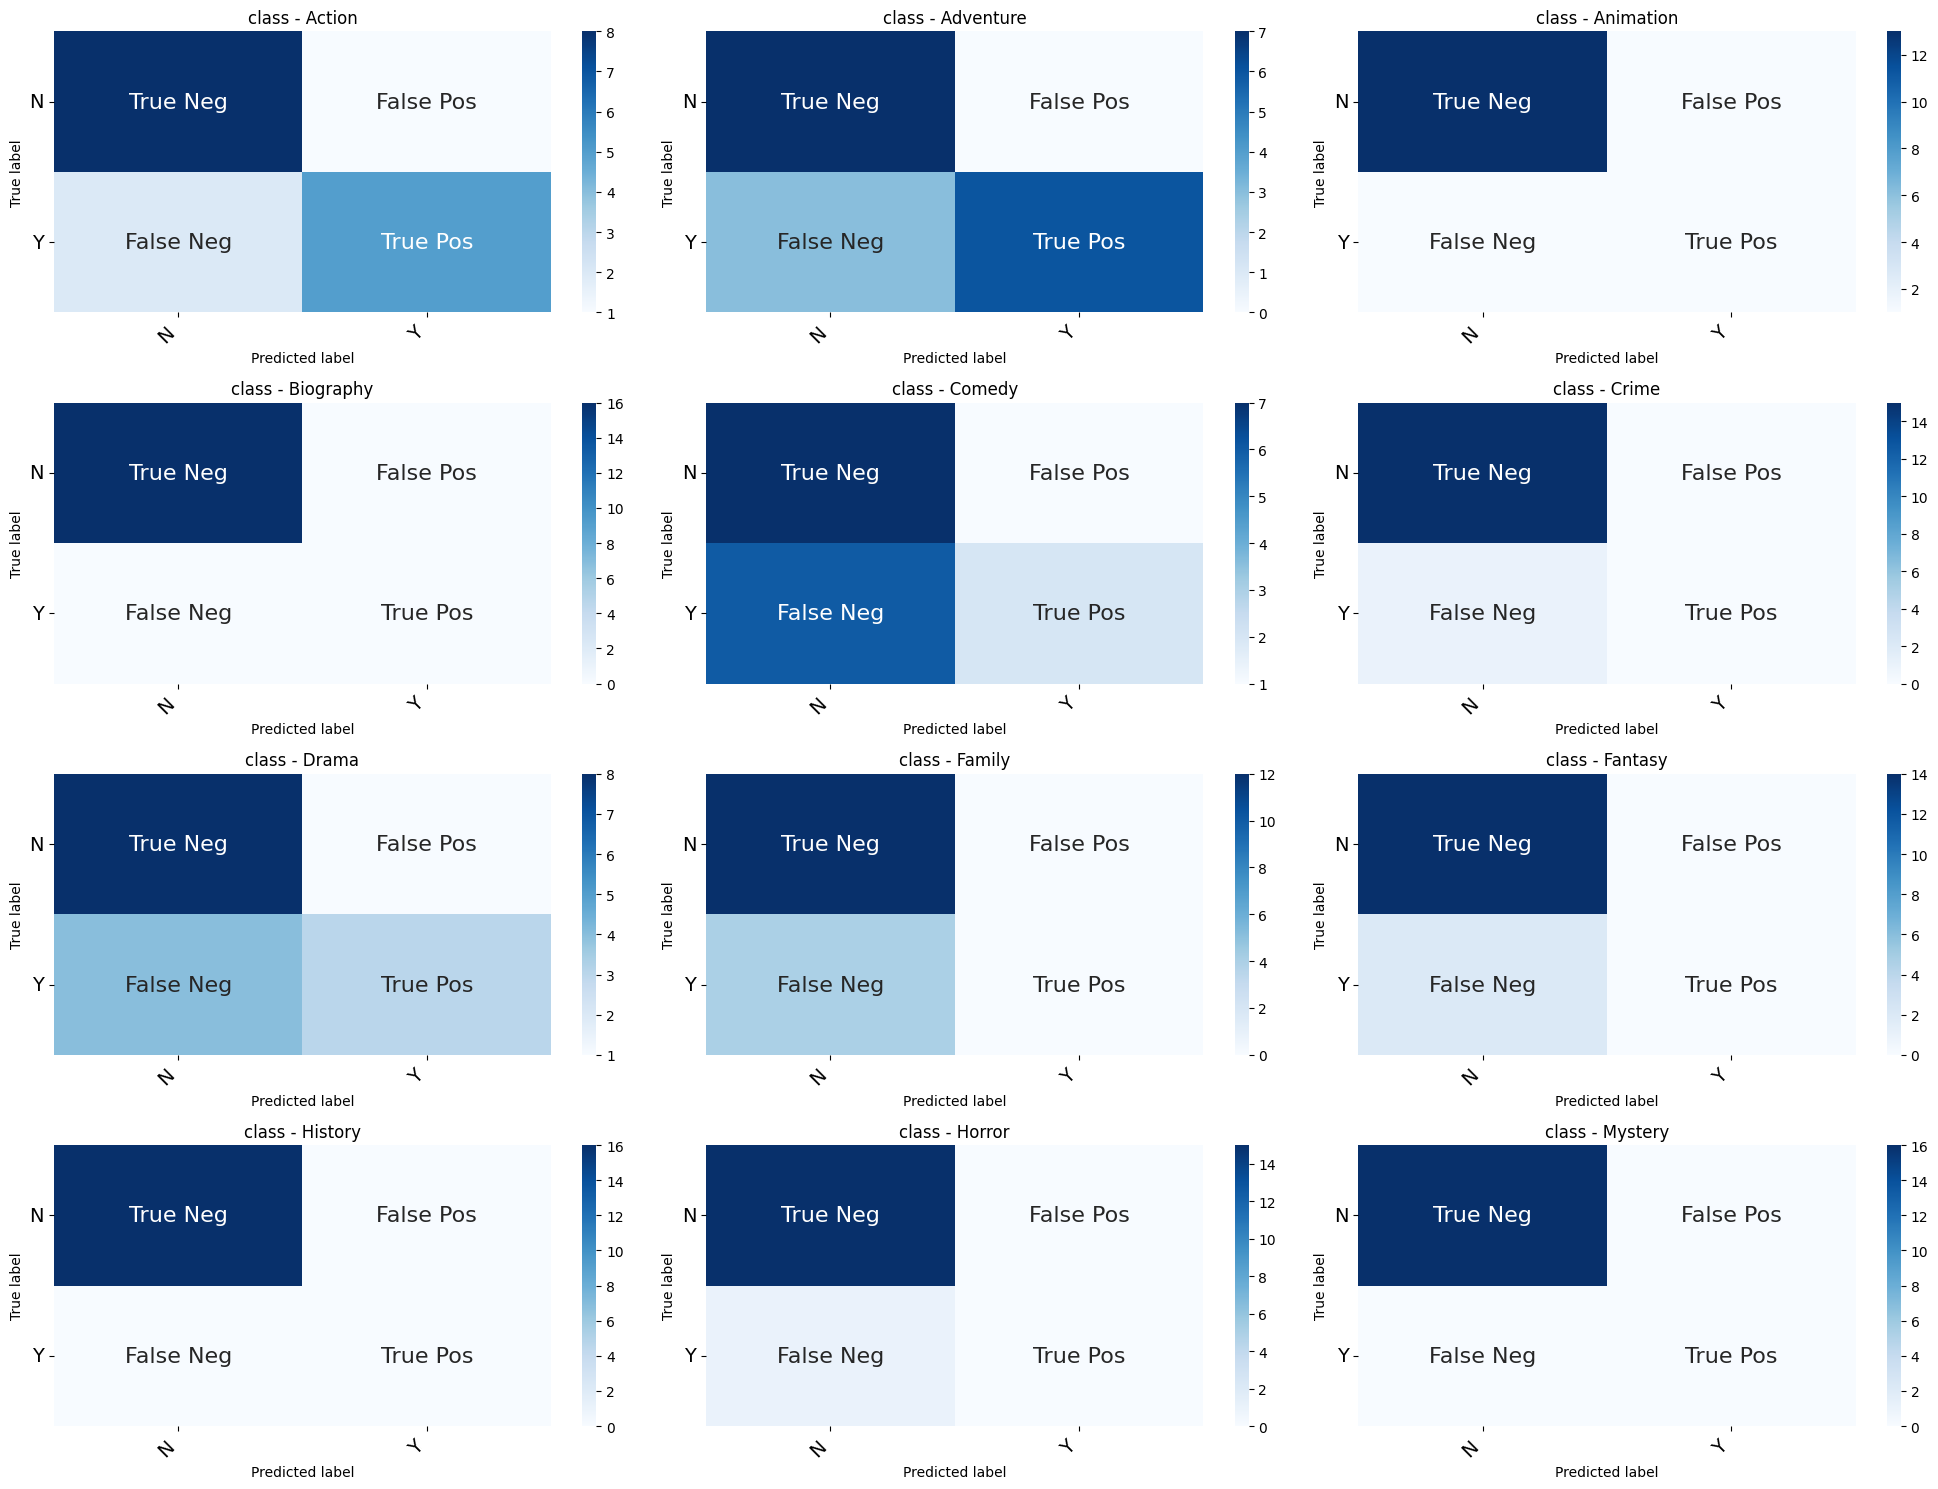

In [322]:
from sklearn.metrics import multilabel_confusion_matrix

matr = multilabel_confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(4, 3, figsize=(20, 15))
    
for axes, cfs_matrix, label in zip(ax.flatten(), matr, multilabel_binarizer.classes_):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()
